In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import zscore
import wave

sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob
import numpy as np
import pandas as pd
import pickle
from math import factorial
import random
from scipy import signal

import scipy.io.wavfile as wavfile

<class 'torch.cuda.FloatTensor'>


In [3]:

from scipy import linspace, pi, exp, zeros
from scipy.fftpack import fft,ifft


def morlet_wavelet(M, w=5.0, s=1.0, complete=True):
    """Complex Morlet wavelet.
    Parameters
    ----------
    M : int
        Length of the wavelet.
    w : float
        Omega0
    s : float
        Scaling factor, windowed from -s*2*pi to +s*2*pi.
    complete : bool
        Whether to use the complete or the standard version.
    Notes:
    ------
    The standard version:
        pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that, this simplified version can cause
        admissibility problems at low values of w.
    The complete version:
        pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For w greater than 5, the
        correction term is negligible.
    Note that the energy of the return wavelet is not normalised
    according to s.
    The fundamental frequency of this wavelet in Hz is given
    by f = 2*s*w*r / M where r is the sampling rate.
    """
    x = linspace(-s*2*pi,s*2*pi,M)
    output = exp(1j*w*x)
    
    if complete:
        output -= exp(-0.5*(w**2))
    
    output *= exp(-0.5*(x**2)) * pi**(-0.25)
    
    return output
def morlet_multi(freqs, widths, samplerates,
                 sampling_windows=7, complete=True):
    """
    Calculate Morlet wavelets with the total energy normalized to 1.
    
    Calls the scipy.signal.wavelet.morlet() function to generate
    Morlet wavelets with the specified frequencies, samplerates, and
    widths (in cycles); see the docstring for the scipy morlet function
    for details. These wavelets are normalized before they are returned.
    
    Parameters
    ----------
    freqs : {float, array_like of floats}
        The frequencies of the Morlet wavelets.
    widths : {float, array_like floats}
        The width(s) of the wavelets in cycles. If only one width is passed
        in, all wavelets have the same width. If len(widths)==len(freqs),
        each frequency is paired with a corresponding width. If
        1<len(widths)<len(freqs), len(freqs) must be evenly divisible by
        len(widths) (i.e., len(freqs)%len(widths)==0). In this case widths
        are repeated such that (1/len(widths))*len(freq) neigboring wavelets
        have the same width -- e.g., if len(widths)==2, the the first and
        second half of the wavelets have widths of widths[0] and width[1]
        respectively, and if len(widths)==3 the first, middle, and last
        third of wavelets have widths of widths[0], widths[1], and widths[2]
        respectively.
    samplerates : {float, array_like floats}
        The sample rate(s) of the signal (e.g., 200 Hz).
    sampling_windows : {float, array_like of floates},optional
        How much of the wavelets is sampled. As sampling_window increases,
        the number of samples increases and thus the samples near the edge
        approach zero increasingly closely. If desired different values can
        be specified for different wavelets (the syntax for multiple sampling
        windows is the same as for widths). One value >= 7 is recommended.
    complete : {bool},optional
        Whether to generate a complete or standard approximation to
        the complete version of a Morlet wavelet. Complete should be True,
        especially for low (<=5) values of width. See
        scipy.signal.wavelet.morlet() for details.
    
    Returns
    -------
    A 2-D (frequencies * samples) array of Morlet wavelets.
    
    Notes
    -----
    The in scipy versions <= 0.6.0, the scipy.signal.wavelet.morlet()
    code contains a bug. Until it is fixed in a stable release, this
    code calls a local fixed version of the scipy function.
    
    Examples
    --------
    >>> wavelet = morlet_multi(10,5,200)
    >>> wavelet.shape
    (1, 112)
    >>> wavelet = morlet_multi([10,20,30],5,200)
    >>> wavelet.shape
    (3, 112)
    >>> wavelet = morlet_multi([10,20,30],[5,6,7],200)
    >>> wavelet.shape
    (3, 112)
    """
    # ensure the proper dimensions
    freqs = np.atleast_1d(freqs)
    widths = np.atleast_1d(widths)
    samplerates = np.atleast_1d(samplerates).astype(np.float64)
    sampling_windows = np.atleast_1d(sampling_windows)

    # check input:
    if len(freqs) < 1:
        raise ValueError("At least one frequency must be specified!")
    if len(widths) < 1 or len(freqs)%len(widths) != 0:
        raise ValueError("Freqs and widths are not compatible: len(freqs) must "+
                         "be evenly divisible by len(widths).\n"+
                         "len(freqs) = "+str(len(freqs))+"\nlen(widths) = "+
                         str(len(widths)))
    if len(samplerates) < 1 or len(freqs)%len(samplerates) != 0:
        raise ValueError("Freqs and samplerates are not compatible:"+
                         "len(freqs) must be evenly divisible by"+
                         "len(samplerates).\nlen(freqs) = "+str(len(freqs))+
                         "\nlen(samplerates) = "+str(len(samplerates)))
    if len(sampling_windows) < 1 or len(freqs)%len(sampling_windows) != 0:
        raise ValueError("Freqs and sampling_windows are not compatible:"+
                         "len(freqs) must be evenly divisible by"+
                         "len(sampling_windows).\nlen(freqs) = "+str(len(freqs))+
                         "\nlen(sampling_windows) = "+str(len(sampling_windows)))
    
    # make len(widths)==len(freqs):
    widths = widths.repeat(len(freqs)/len(widths))
    
    # make len(samplerates)==len(freqs):
    samplerates = samplerates.repeat(len(freqs)/len(samplerates))

    # make len(sampling_windows)==len(freqs):
    sampling_windows = sampling_windows.repeat(len(freqs)/len(sampling_windows))
    # std. devs. in the time domain:
    st = widths/(2*np.pi*freqs)
    
    # determine number of samples needed:
    samples = np.ceil(st*samplerates*sampling_windows)
    
    # each scale depends on frequency, samples, width, and samplerates:
    scales = (freqs*samples)/(2.*widths*samplerates)
    
    # generate list of unnormalized wavelets:
    wavelets = [morlet_wavelet(int(samples[i]),w=widths[i],s=scales[i],
                               complete=complete)
                for i in range(len(scales))]
    
    # generate list of energies for the wavelets:
    energies = [np.sqrt(np.sum(np.power(np.abs(wavelets[i]),2.))/samplerates[i])
                for i in range(len(scales))]
    
    # normalize the wavelets by dividing each one by its energy:
    norm_wavelets = [wavelets[i]/energies[i]
                     for i in range(len(scales))]
    
    return norm_wavelets

def reshape_to_2d(data,axis):
    """Reshape data to 2D with specified axis as the 2nd dimension."""
    # get the shape, rank, and the length of the chosen axis
    

    dshape = data.shape
    rnk = len(dshape)
    n = dshape[axis]
    # convert negative axis to positive axis
    if axis < 0: 
        axis = axis + rnk
    # determine the new order of the axes
    newdims = np.r_[0:axis,axis+1:rnk,axis]

    # reshape and transpose the data
    temp = np.transpose(data,tuple(newdims))
    temp2 = [np.prod(dshape,axis=0)/n,n]
    for t in range(len(temp2)):
        temp2[t] = int(temp2[t])
    newdata = np.reshape(temp,
                         temp2)
    
    # make sure we have a copy
    #newdata = newdata.copy()

    return newdata

def reshape_from_2d(data,axis,dshape):
    """Reshape data from 2D back to specified dshape."""
    # set the rank of the array
    rnk = len(dshape)

    # fix negative axis to be positive
    if axis < 0: 
        axis = axis + rnk

    # determine the dims from reshape_to_2d call
    newdims = np.r_[0:axis,axis+1:rnk,axis]

    # determine the transposed shape and reshape it back
    tdshape = np.take(dshape,newdims,0)
    ret = np.reshape(data,tuple(tdshape))

    # figure out how to retranspose the matrix
    vals = list(range(rnk))
    olddims = vals[:axis] + [rnk-1] +vals[axis:rnk-1]
    ret = np.transpose(ret,tuple(olddims))
    
    # make sure we have a copy
    #ret = ret.copy()
    return ret

def phase_pow_multi(freqs, dat,  samplerates=None, widths=5,
                    to_return='both', time_axis=-1,
                    conv_dtype=np.complex64, freq_name='freqs',
                    **kwargs):
    """
    Calculate phase and power with wavelets across multiple events.
    Calls the morlet_multi() and fconv_multi() functions to convolve
    dat with Morlet wavelets.  Phase and power over time across all
    events are calculated from the results. Time/samples should
    include a buffer before onsets and after offsets of the events of
    interest to avoid edge effects.
    Parameters
    ----------
    freqs : {int, float, array_like of ints or floats}
        The frequencies of the Morlet wavelets.
    dat : {array_like}
        The data to determine the phase and power of. Sample rate(s)
        and time dimension must be specified as attributes of dat or
        in the key word arguments.  The time dimension should include
        a buffer to avoid edge effects.
    samplerates : {float, array_like of floats}, optional
        The sample rate(s) of the signal. Must be specified if dat is
        not a TimeSeries instance. If dat is a TimeSeries instance,
        any value specified here will be replaced by the value stored
        in the samplerate attribute.
    widths : {float, array_like of floats},optional
        The width(s) of the wavelets in cycles. See docstring of
        morlet_multi() for details.
    to_return : {'both','power','phase'}, optional
        Specify whether to return power, phase, or both.        
    time_axis : {int},optional
        Index of the time/samples dimension in dat. Must be specified
        if dat is not a TimeSeries instance. If dat is a TimeSeries
        instance any value specified here will be replaced by the
        value specified in the tdim attribute.
    conv_dtype : {numpy.complex*},optional
        Data type for the convolution array. Using a larger dtype
        (e.g., numpy.complex128) can increase processing time.
        This value influences the dtype of the output array. In case of
        numpy.complex64 the dtype of the output array is numpy.float32.
        Higher complex dtypes produce higher float dtypes in the output.
    freq_name : {string},optional
        Name of frequency dimension of the returned TimeSeries object
        (only used if dat is a TimeSeries instance).
    **kwargs : {**kwargs},optional
        Additional key word arguments to be passed on to morlet_multi().
    
    Returns
    -------
    Array(s) of phase and/or power values as specified in to_return. The
    returned array(s) has/have one more dimension than dat. The added
    dimension is for the frequencies and is inserted as the first
    dimension.
    """

    dat_is_ts = False # is dat a TimeSeries instance?
    if samplerates is None:
        raise ValueError('Samplerate must be specified unless you provide a TimeSeries!')

    # convert the time_axis to positive index
    if time_axis < 0: 
        time_axis += len(dat.shape)
    
    # ensure proper dimensionality (needed for len call later):
    freqs = np.atleast_1d(freqs)
    
    # check input values:
    if to_return != 'both' and to_return != 'power' and to_return != 'phase':
        raise ValueError("to_return must be \'power\', \'phase\', or \'both\' to "+
                         "specify whether power, phase, or both are to be "+
                         "returned. Invalid value: %s " % to_return)

    if not np.issubdtype(conv_dtype,np.complex):
        raise ValueError("conv_dtype must be a complex data type!\n"+
                         "Invalid value: "+str(conv_dtype))

    # generate list of wavelets:
    wavelets = morlet_multi(freqs,widths,samplerates,**kwargs)
        
    # make sure we have at least as many data samples as wavelet samples
    if (np.max([len(i) for i in wavelets]) >  dat.shape[time_axis]):
        raise ValueError("The number of data samples is insufficient compared "+
                         "to the number of wavelet samples. Try increasing "+
                         "data samples by using a (longer) buffer.\n data "+
                         "samples: "+str(dat.shape[time_axis])+"\nmax wavelet "+
                         "samples: "+str(np.max([len(i) for i in wavelets])))
    
    # reshape the data to 2D with time on the 2nd dimension
    origshape = dat.shape
    eegdat = reshape_to_2d(dat, int(time_axis)) #.view(np.ndarray)

    # for efficiency pre-generate empty array for convolution:
    wav_coef = np.empty((eegdat.shape[0]*len(freqs),
                         eegdat.shape[1]),dtype=conv_dtype)
    
    # populate this array with the convolutions:
    i=0
    step = len(eegdat)
    for wav in wavelets:
        wc = fconv_multi(wav,eegdat,'same')
        wav_coef[i:i+step] = wc
        i+=step
        # for ev_dat in eegdat:
        #     wav_coef[i]=np.convolve(wav,ev_dat,'same')
        #     #wav_coef[i]=scipy.signal.fftconvolve(ev_dat,wav,'same')
        #     i+=1
    
    # Determine shape for ouput arrays with added frequency dimension:
    newshape = list(origshape)
    # freqs must be first for reshape_from_2d to work
    newshape.insert(0,len(freqs))
    newshape = tuple(newshape)

    # must add to the time axis, too
    time_axis += 1

    # calculate power (wav_coef values are complex, so taking the
    # absolute value is necessary before taking the power):
    power = np.abs(wav_coef)**2
    # reshape to new shape:
    power = reshape_from_2d(power,time_axis,newshape)
    
    return power
    
def morlet(freq,t,width):
    """Generate a Morlet wavelet for specified frequncy for times t.
    The wavelet will be normalized so the total energy is 1.  width
    defines the ``width'' of the wavelet in cycles.  A value >= 5 is
    suggested.
    """
    sf = float(freq)/float(width)
    st = 1./(2*np.pi*sf)
    A = 1./np.sqrt(st*np.sqrt(np.pi))
    y = A*np.exp(-np.power(t,2)/(2*np.power(st,2)))*np.exp(2j*np.pi*freq*t)
    return y
def fconv_multi(in1, in2, mode='full'):
    """
    Convolve multiple 1-dimensional arrays using FFT.
    Calls scipy.signal.fft on every row in in1 and in2, multiplies
    every possible pairwise combination of the transformed rows, and
    returns an inverse fft (by calling scipy.signal.ifft) of the
    result. Therefore the output array has as many rows as the product
    of the number of rows in in1 and in2 (the number of colums depend
    on the mode).
    
    Parameters
    ----------
    in1 : {array_like}
        First input array. Must be arranged such that each row is a
        1-D array with data to convolve.
    in2 : {array_like}
        Second input array. Must be arranged such that each row is a
        1-D array with data to convolve.
    mode : {'full','valid','same'},optional
        Specifies the size of the output. See the docstring for
        scipy.signal.convolve() for details.
    
    Returns
    -------
    Array with in1.shape[0]*in2.shape[0] rows with the convolution of
    the 1-D signals in the rows of in1 and in2.
    """    
    # ensure proper number of dimensions
    in1 = np.atleast_2d(in1)
    in2 = np.atleast_2d(in2)

    # get the number of signals and samples in each input
    num1,s1 = in1.shape
    num2,s2 = in2.shape
    
    # see if we will be returning a complex result
    complex_result = (np.issubdtype(in1.dtype, np.complex) or
                      np.issubdtype(in2.dtype, np.complex))

    # determine the size based on the next power of 2
    actual_size = s1+s2-1
    size = np.power(2,next_pow2(actual_size))

    # perform the fft of each row of in1 and in2:
    #in1_fft = np.empty((num1,size),dtype=np.complex128)
    in1_fft = np.empty((num1,size),dtype=np.complex)
    for i in range(num1):
        in1_fft[i] = fft(in1[i],size)
    #in2_fft = np.empty((num2,size),dtype=np.complex128)
    in2_fft = np.empty((num2,size),dtype=np.complex)
    for i in range(num2):
        in2_fft[i] = fft(in2[i],size)
    
    # duplicate the signals and multiply before taking the inverse
    in1_fft = in1_fft.repeat(num2,axis=0)
    in1_fft *= np.vstack([in2_fft]*num1)
    ret = ifft(in1_fft)

    # delete to save memory
    del in1_fft, in2_fft
    
    # strip of extra space if necessary
    ret = ret[:,:actual_size]
    
    # determine if complex, keeping only real if not
    if not complex_result:
        ret = ret.real
    
    # now only keep the requested portion
    if mode == "full":
        return ret
    elif mode == "same":
        if s1 > s2:
            osize = s1
        else:
            osize = s2
        return centered(ret,(num1*num2,osize))
    elif mode == "valid":
        return centered(ret,(num1*num2,np.abs(s2-s1)+1))
def next_pow2(n):
    """
    Returns p such that 2 ** p >= n
    """
    p = int(np.floor(np.log2(n)))
    if 2 **  p == n:
        return p
    else:
        return p + 1
    
def centered(arr, newsize):
    """
    Return the center newsize portion of the input array.
    Parameters
    ----------
    arr : {array}
        Input array
    newsize : {tuple of ints}
        A tuple specifing the size of the new array.
    Returns
    -------
    A center slice into the input array
    
    Note
    ----
    Adapted from scipy.signal.signaltools._centered
        
    """
    # Don't make a copy of newsize when creating array:
    newsize = np.asarray(newsize)
    # Do make a copy of arr.shape when creating array:
    currsize = np.array(arr.shape)
    # determine start- & end-indices and slice:
    startind = (currsize - newsize) / 2
    endind = startind + newsize
    myslice = [slice(int(startind[k]), int(endind[k])) for k in range(len(endind))]
    return arr[tuple(myslice)]

In [4]:
filenames = []
subj = '01'
for fn in glob.glob(join('F:\\', 'AudioMNIST', 'data', subj, '*')):
    filenames.append(fn)

In [142]:
all_fn = []
all_subj = glob.glob(join('F:', 'AudioMNIST', 'data', '*'))
for subjcount, subj in enumerate(all_subj):
    subj = subj.split('\\')[-1]
    for fn in glob.glob(join('F:\\', 'AudioMNIST', 'data', subj, '*')):
        wav = wave.open(fn, 'rb')
        length = wav.getnframes()
        info = fn.split('\\')
        audio_info = info[-1].split('_')
        rec = audio_info[2][:-4]
        rec_int = int(rec)
        all_fn.append(dict(filename=fn,
                           digit=int(audio_info[0]),
                           subjid=int(audio_info[1]),
                           rec=int(audio_info[2][:-4]),
                           length=length,
                           split_group=subjcount%5,
                           rec_split=int(audio_info[2][:-4])%10),
                           )
all_files = pd.DataFrame(all_fn)
print(all_files.head())

Error: file does not start with RIFF id

In [141]:
print(all_files.filename[0])

F:\AudioMNIST\data\01\0_01_0.wav


47998


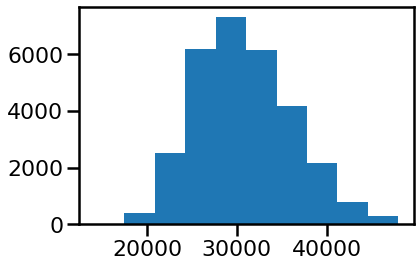

In [83]:
plt.hist(all_files.length)
print(all_files.length.max())

In [154]:
all_files.to_csv("files_info.csv")
all_files.to_pickle("files_info.dil")

In [5]:
all_files = pd.read_pickle('files_info.dil')

In [6]:
all_files

,digit,subjid,rec,length,split_group,rec_split,dat_idx
0,0,1,0,35877,0,0,0
1,0,1,1,31356,0,1,1
2,0,1,10,31210,0,0,2
3,0,1,11,29467,0,1,3
4,0,1,12,32852,0,2,4
...,...,...,...,...,...,...,...
29995,9,60,5,34821,4,5,495
29996,9,60,6,34760,4,6,496
29997,9,60,7,36820,4,7,497
29998,9,60,8,36031,4,8,498


In [1]:
48000/200


240.0

In [15]:
maxl = 50000
print()
resample_factor = 200

In [16]:
freqs = np.logspace(np.log(1000), np.log(24000), 50, base=np.e)
last_subj = 0
subj_rcoef = None
subj_targets = None
speed=1.0
for x, f in enumerate(all_files.itertuples()):
    if last_subj != f.subjid:
        if not (subj_rcoef is None):
            subj_dat = np.array(subj_rcoef)
            subj_targ = np.array(subj_targets)
            subj = '{:02}'.format(last_subj)
            np.save(join('F:\\', 'AudioMNIST', 'data', 
                         'data_{}_{:01.2f}'.format(subj, speed)), subj_dat)
            np.save(join('F:\\', 'AudioMNIST', 'data', 
                         'targets_{}_{:01.2f}'.format(subj, speed)), subj_targ)
            print('saved {}'.format(subj))
        subj_rcoef = []
        subj_targets = []
        last_subj = f.subjid
        
    filename = "{}_{:02}_{}.wav".format(f.digit, f.subjid, f.rec)
    fs, dat = wavfile.read(join('F:\\', 'AudioMNIST', 'data', 
                                '{:02}'.format(f.subjid), 
                                filename))
    dat = dat/max_int16
    dat = np.pad(dat, (int(np.floor((maxl - dat.shape[0])/2)),
                   int(np.ceil((maxl - dat.shape[0])/2))), 'constant')
    out = phase_pow_multi(freqs, dat,  samplerates=fs, widths=5,
                    to_return='power', time_axis=-1,
                    conv_dtype=np.complex64, freq_name='freqs',
                    )
    
    rcoef = zscore(signal.resample(out, out.shape[1]//resample_factor, axis=1), axis=1)
    subj_rcoef.append(rcoef)
    subj_targets.append(f.digit)

<ipython-input-3-2ed8694e5588>:286: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if not np.issubdtype(conv_dtype,np.complex):
<ipython-input-3-2ed8694e5588>:34: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(-s*2*pi,s*2*pi,M)
<ipython-input-3-2ed8694e5588>:35: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  output = exp(1j*w*x)
<ipython-input-3-2ed8694e5588>:38: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  output -= exp(-0.5*(w**2))
<ipython-input-3-2ed8694e5588>:40: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  output *= exp(-0.5*(x**2)) * pi**(-0.25)
<ipython-input-3-2ed8694e5588>:385: Fu

saved 01
saved 02
saved 03
saved 04
saved 05
saved 06
saved 07
saved 08
saved 09
saved 10
saved 11
saved 12
saved 13
saved 14
saved 15
saved 16
saved 17
saved 18
saved 19
saved 20
saved 21
saved 22
saved 23
saved 24
saved 25
saved 26
saved 27
saved 28
saved 29
saved 30
saved 31
saved 32
saved 33
saved 34
saved 35
saved 36
saved 37
saved 38
saved 39
saved 40
saved 41
saved 42
saved 43
saved 44
saved 45
saved 46
saved 47
saved 48
saved 49
saved 50
saved 51
saved 52
saved 53
saved 54
saved 55
saved 56
saved 57
saved 58
saved 59


In [19]:
from scipy.io import wavfile
from audiotsm import phasevocoder
from audiotsm.io.array import ArrayReader, ArrayWriter
def scale_audio(indat,fs, outfile, speed, factor=2):
    
    reader = ArrayReader(indat[np.newaxis])
    writer = ArrayWriter(channels=1)
    tsm = phasevocoder(reader.channels, speed=speed)
    tsm.run(reader, writer)
    if outfile:
        wavfile.write(outfile, fs, writer.data[0].astype(np.int16)*factor)
    return writer.data[0].astype(np.int16)*factor

In [10]:
 max_int16 = 2**15

In [21]:
freqs = np.logspace(np.log(1000), np.log(24000), 50, base=np.e)
last_subj = 0
subj_rcoef = None
subj_targets = None
speeds = [.1, .2, .4, .8, 1.25, 2.5, 5, 10][::-1]
for speed in speeds:
    print("BEEP BEEP SPEED IS ", speed)
    factor = 1/speed
    for x, f in enumerate(all_files.itertuples()):
        if last_subj != f.subjid:
            if not (subj_rcoef is None):
                subj_dat = np.array(subj_rcoef)
                subj_targ = np.array(subj_targets)
                subj = '{:02}'.format(last_subj)
                np.save(join('F:\\', 'AudioMNIST', 'data', 
                             'data_{}_{:01.2f}'.format(subj, speed)), subj_dat)
                np.save(join('F:\\', 'AudioMNIST', 'data', 
                             'targets_{}_{:01.2f}'.format(subj, speed)), subj_targ)
                print('saved {}'.format(subj))
            subj_rcoef = []
            subj_targets = []
            last_subj = f.subjid

        filename = "{}_{:02}_{}.wav".format(f.digit, f.subjid, f.rec)
        fs, dat = wavfile.read(join('F:\\', 'AudioMNIST', 'data', 
                                    '{:02}'.format(f.subjid), 
                                    filename))
        dat = np.pad(dat, (int(np.floor((maxl - dat.shape[0])/2)),
                   int(np.ceil((maxl - dat.shape[0])/2))), 'constant')
        
        dat = scale_audio(dat, fs, None, speed, factor=factor)    
        # NOTE: BIG NOTE: Factor might have to change. right now its 1/speed
        dat = dat/max_int16
        out = phase_pow_multi(freqs, dat,  samplerates=fs, widths=5,
                        to_return='power', time_axis=-1,
                        conv_dtype=np.complex64, freq_name='freqs',
                        )

        rcoef = zscore(signal.resample(out, out.shape[1]//resample_factor, axis=1), axis=1)
        subj_rcoef.append(rcoef)
        subj_targets.append(f.digit)


BEEP BEEP SPEED IS  10


<ipython-input-3-2ed8694e5588>:286: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if not np.issubdtype(conv_dtype,np.complex):
<ipython-input-3-2ed8694e5588>:34: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(-s*2*pi,s*2*pi,M)
<ipython-input-3-2ed8694e5588>:35: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  output = exp(1j*w*x)
<ipython-input-3-2ed8694e5588>:38: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  output -= exp(-0.5*(w**2))
<ipython-input-3-2ed8694e5588>:40: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  output *= exp(-0.5*(x**2)) * pi**(-0.25)
<ipython-input-3-2ed8694e5588>:385: Fu

saved 01
saved 02
saved 03
saved 04
saved 05
saved 06
saved 07
saved 08
saved 09
saved 10
saved 11
saved 12
saved 13
saved 14
saved 15
saved 16
saved 17
saved 18
saved 19
saved 20
saved 21
saved 22
saved 23
saved 24
saved 25
saved 26
saved 27
saved 28
saved 29
saved 30
saved 31
saved 32
saved 33
saved 34
saved 35
saved 36
saved 37
saved 38
saved 39
saved 40
saved 41
saved 42
saved 43
saved 44
saved 45
saved 46
saved 47
saved 48
saved 49
saved 50
saved 51
saved 52
saved 53
saved 54
saved 55
saved 56
saved 57
saved 58
saved 59
BEEP BEEP SPEED IS  5
saved 60
saved 01
saved 02
saved 03
saved 04
saved 05
saved 06
saved 07
saved 08
saved 09
saved 10
saved 11
saved 12
saved 13
saved 14
saved 15
saved 16
saved 17
saved 18
saved 19
saved 20
saved 21
saved 22
saved 23
saved 24
saved 25
saved 26
saved 27
saved 28
saved 29
saved 30
saved 31
saved 32
saved 33
saved 34
saved 35
saved 36
saved 37
saved 38
saved 39
saved 40
saved 41
saved 42
saved 43
saved 44
saved 45
saved 46
saved 47
saved 48
saved 

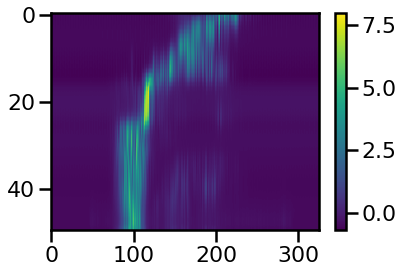

In [203]:
plt.imshow(rcoef, aspect='auto')
plt.colorbar()

In [170]:
one_dat = np.array(rcoefs)
np.save(join('F:\\', 'AudioMNIST', 'data', '01', '01_0.50.dat'), one_dat)